# 概述

集成方法效果好的前提：

假定二分类的n个成员分类器都有相同的出错率，每个分类器都是独立的，出错率不相关

In [1]:
from scipy.special import comb
import math
import numpy as np
import matplotlib.pyplot as plt

def ensemble_error(n_classifier,error):
    '''计算集成分类器出错率
    @parameter n_classifier 分类器数量
    @parameter error 成员分类器错误率'''
    k_start=math.ceil(n_classifier/2.0) 
    probs = [comb(n_classifier,k) *  #求从n_classifier中取出k的组合数量
    error**k *\
    (1-error)**(n_classifier-k)\
    for k in range(k_start,n_classifier+1)]
    return sum(probs)

print (ensemble_error(n_classifier=11,error=0.25))

error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error=error) for error in error_range]
plt.plot(error_range,ens_errors,label='Ensemble error',linewidth=2)
plt.plot(error_range,error_range,linestyle='--',label='Base error')
plt.xlabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

0.03432750701904297


<Figure size 640x480 with 1 Axes>

# 多数投票分类器

In [2]:
#实现基于类别预测的加权投票
bc=np.bincount([0,0,1],weights=[0.2,0.2,0.6])#计数矩阵中每个值的出现次数或概率
am =np.argmax(bc)#沿轴取最大值
print(bc,am)

#实现基于类别预测概率的加权投票
ex = np.array([[0.9,0.1],
              [0.8,0.2],
              [0.4,0.6]])
p=np.average(ex,axis=0,weights=[0.2,0.2,0.6])#沿轴取平均值
print(p)

[0.4 0.6] 1
[0.58 0.42]


In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

iris = datasets.load_iris()
X,y =iris.data[50:,[1,2]],iris.target[50:]
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size=0.5)
clf1 = LogisticRegression(penalty='l2',C=0.001,solver='lbfgs')
clf2 = DecisionTreeClassifier(max_depth=1)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2)
pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic Regression','Decision Tree','KNN']
print('10-fold cross validation:\n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

10-fold cross validation:

ROC AUC: 0.96 (+/- 0.10) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.09) [Decision Tree]
ROC AUC: 0.86 (+/- 0.20) [KNN]


In [4]:
#集成投票
mv_clf = VotingClassifier(estimators=[('lr',pipe1),('dt',clf2),('knn',pipe3)], voting='soft', weights=[2,1,1])
clf_labels = ['Logistic Regression','Decision Tree','KNN','Majority Voting']
all_clf =[pipe1, clf2, pipe3, mv_clf]

for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(clf,X_train,y_train,cv=10,scoring='roc_auc')
    print ("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

ROC AUC: 0.96 (+/- 0.10) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.09) [Decision Tree]
ROC AUC: 0.86 (+/- 0.20) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


# 评估与调优集成分类器

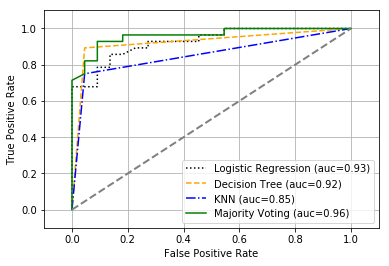

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black','orange','blue','green']
linearstyles=[':','--','-.','-']
for clf,label,clr,ls in zip(all_clf,clf_labels,colors,linearstyles):
    y_pred=clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds=roc_curve(y_true=y_test,y_score=y_pred,pos_label=2)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label='%s (auc=%.2f)' % (label,roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [6]:
#调优集成分类器
from sklearn.model_selection import GridSearchCV
params = {'dt__max_depth': [1,2],
         'lr__clf__C':[0.001,0.1,100.0]}
grid = GridSearchCV(estimator=mv_clf,param_grid=params,cv=10,scoring='roc_auc',iid=False)
grid.fit(X_train,y_train)
print ('Best parameters: %s' % grid.best_params_)
print ('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'dt__max_depth': 1, 'lr__clf__C': 0.001}
Accuracy: 0.97


# bagging
bagging 算法是降低模型方差的一种有效方法，然而bagging在降低模型偏差方面的作用不大

In [10]:
import pandas as pd
df_wine=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns=['Class label','Alcohol',
                'Malic acid','Ash',
                'Alcalinity of ash',
                'Magnesium','Total phenols',
                'Flavanoids','Nonflavanoid phenols',
                'Proanthocyanins',
                'Color intensity','Hue',
                'OD280/OD315 of diluted wines',
                'Proline']
df_wine=df_wine[df_wine['Class label'] != 1]
y=df_wine['Class label'].values
X=df_wine[['Alcohol','Hue']].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4)

from sklearn.ensemble import BaggingClassifier
tree= DecisionTreeClassifier(criterion='entropy',max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1)
from sklearn.metrics import accuracy_score
tree =tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
tree_train= accuracy_score(y_train,y_train_pred)
tree_test=accuracy_score(y_test,y_test_pred)
print ('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train,tree_test))

bag=bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print ('Bagging train/test accuracies %.3f/%.3f' % (bag_train,bag_test))

Decision tree train/test accuracies 1.000/0.896
Bagging train/test accuracies 1.000/0.958


# 自适应boosting

AdaBoost算法是降低模型偏差的一种有效方法，然而会导致模型的方差提高

In [14]:
from sklearn.ensemble import AdaBoostClassifier
tree= DecisionTreeClassifier(criterion='entropy',max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1)
tree =tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
tree_train= accuracy_score(y_train,y_train_pred)
tree_test=accuracy_score(y_test,y_test_pred)
print ('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train,tree_test))

ada = ada.fit(X_train,y_train)
y_train_pred=ada.predict(X_train)
y_test_pred=ada.predict(X_test)
ada_train= accuracy_score(y_train,y_train_pred)
ada_test=accuracy_score(y_test,y_test_pred)
print ('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.958
